In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

gpu = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [3]:
image_path = glob.glob(r'F:\course_video\WY0x000172 GAN生成对抗网络入门与实战\代码和数据集\2.0部分数据集\二次元人物头像\images\*.jpg')
print(len(image_path))

def load_preprosess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_crop_or_pad(image, 64, 64) # 对图片根据要求大小进行裁剪或者扩充到指定大小
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

image_ds = tf.data.Dataset.from_tensor_slices(image_path)
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_count = len(image_path)
BATCH_SIZE = 256
image_ds = image_ds.map(load_preprosess_image, num_parallel_calls=AUTOTUNE).shuffle(image_count).batch(BATCH_SIZE).prefetch(AUTOTUNE)
print(image_ds)

63565
<PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>


In [4]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))   #8*8*256

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())             #8*8*128

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())             #16*16*128
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())             #32*32*32
    

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
                                              #64*64*3
    
    return model



def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))      # 32*32*32

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))      # 16*16*64
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
#    model.add(layers.Dropout(0.3))      # 8*8*128
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())       # 4*4*256

    model.add(layers.GlobalAveragePooling2D())
    
    model.add(layers.Dense(1024))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(1))

    return model


generator = generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

discriminator = discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00015634]], shape=(1, 1), dtype=float32)


In [5]:
def discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
discriminator_optimizer = tf.keras.optimizers.RMSprop(5e-5)

EPOCHS = 800
noise_dim = 100
num_examples_to_generate = 4  # 测试样本数

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [6]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    for idx, grad in enumerate(gradients_of_discriminator):
        gradients_of_discriminator[idx] = tf.clip_by_value(grad, -0.01, 0.01)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [7]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(6, 6))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 2, i+1)
        plt.imshow((predictions[i, :, :, :] + 1)/2)
        plt.axis('off')

#    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [8]:
epoch_loss_avg_gen = tf.keras.metrics.Mean('g_loss')
epoch_loss_avg_disc = tf.keras.metrics.Mean('d_loss')

g_loss_results = []
d_loss_results = []

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            epoch_loss_avg_gen(g_loss)
            epoch_loss_avg_disc(d_loss)
            
        g_loss_results.append(epoch_loss_avg_gen.result())
        d_loss_results.append(epoch_loss_avg_disc.result())
        
        epoch_loss_avg_gen.reset_states()
        epoch_loss_avg_disc.reset_states()
#            print('.', end='')
#        print()
        if epoch%10 == 0:
#            print('epoch:', epoch, 'g_loss:', g_loss, 'd_loss:', d_loss)
            generate_and_save_images(generator,
                                     epoch + 1,
                                     seed)


    generate_and_save_images(generator,
                           epochs,
                           seed)

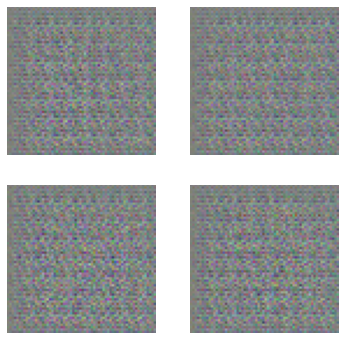

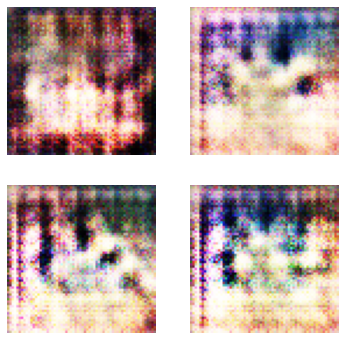

KeyboardInterrupt: 

In [9]:
train(image_ds, EPOCHS)

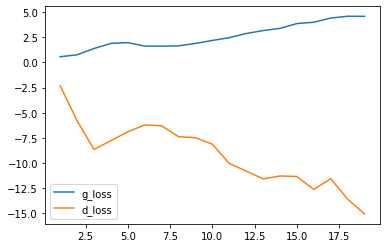

In [10]:
plt.plot(range(1, len(g_loss_results)+1), g_loss_results, label='g_loss')
plt.plot(range(1, len(d_loss_results)+1), d_loss_results, label='d_loss')
plt.legend()

In [11]:
# 保存模型
generator.save('gen_model/generate_WGAN.h5')